In [17]:
import pandas as pd
pd.set_option('display.max_columns', 30)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv('hmeq_train.csv')
df

,id,default,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,16537,0,20900,58299.0,78684.00,DebtCon,NaN,3.0,0.0,0.0,98.662820,0.0,16.0,38.972004
1,14800,0,17400,56111.0,114521.00,HomeImp,Office,2.0,NaN,2.0,154.855524,1.0,24.0,38.695084
2,11317,0,8700,57254.0,86883.00,HomeImp,Other,16.0,0.0,0.0,172.166563,0.0,28.0,25.043437
3,13023,0,6000,69876.0,94394.07,HomeImp,Other,0.0,0.0,1.0,179.566667,0.0,32.0,NaN
4,11652,0,9700,75566.0,92066.00,DebtCon,Office,14.0,0.0,0.0,94.987922,0.0,8.0,25.161183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,11056,1,15000,47000.0,73900.00,DebtCon,Office,2.0,1.0,5.0,73.100000,1.0,16.0,NaN
5194,14457,0,24300,50826.0,68199.00,DebtCon,Other,7.0,0.0,0.0,71.181989,1.0,19.0,36.496201
5195,15958,0,22400,98238.0,135561.00,DebtCon,ProfExe,NaN,0.0,0.0,194.282099,0.0,20.0,29.373607
5196,11117,0,24400,112178.0,159638.00,DebtCon,Mgr,17.0,0.0,0.0,197.969559,0.0,26.0,33.130176


### **Data Preprocessing**

##### Data cleaning

In [19]:
df.duplicated().sum()

0

In [20]:
df.isnull().sum()

id                       0
default                  0
loan_amount              0
mortgage_amount        451
property_value          95
loan_reason            223
occupation             241
occupation_length      450
derogatory_reports     619
late_payments          503
oldest_credit_line     267
recent_credit          436
credit_number          196
ratio                 1113
dtype: int64

 Handling Categorical Columns

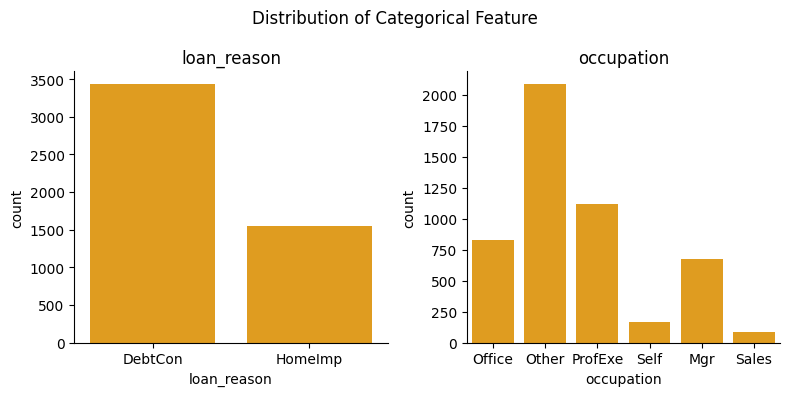

In [21]:
def distribution_cate(dataframe, columns, row_num, col_num,figsize = (8,4), chart_color='pink'):
    list_distribution = dataframe[columns]
    fig, axs = plt.subplots(row_num, col_num, figsize=figsize)
    axs = axs.ravel()
    for ind, col in enumerate(list_distribution):
        sns.countplot(data=dataframe, x=col, ax=axs[ind], color=chart_color)
        axs[ind].set_title(col)
    sns.despine(right=True)
    plt.suptitle('Distribution of Categorical Feature')
    plt.tight_layout()
    plt.show()
    return


cols_cat = df.select_dtypes(include=['object'])

distribution_cate(df, cols_cat.columns, 1,2, chart_color='orange')

In [22]:
# loan_reason
df['loan_reason'] = df['loan_reason'].fillna('Unknown')

# occupation
occupation_mode = df['occupation'].mode()[0]
df['occupation'] = df['occupation'].fillna(occupation_mode)

Handling Numerical Columns

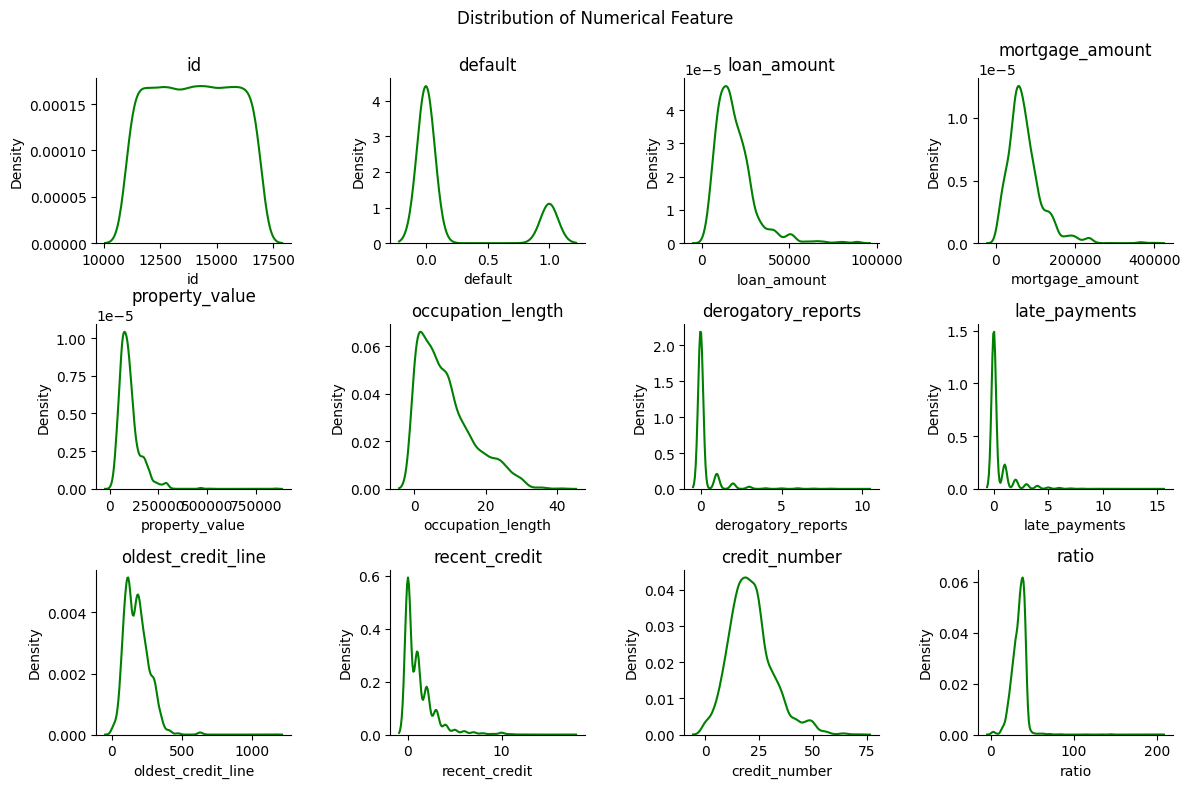

In [23]:
def distribution_nume(dataframe, columns, row_num, col_num,figsize = (12,8), chart_color='pink'):
    list_distribution = dataframe[columns]
    fig, axs = plt.subplots(row_num, col_num, figsize=figsize)
    axs = axs.ravel()
    for ind, col in enumerate(list_distribution):
        sns.kdeplot(data=dataframe, x=col, ax=axs[ind], color=chart_color)
        axs[ind].set_title(col)
    sns.despine(right=True)
    plt.suptitle('Distribution of Numerical Feature')
    plt.tight_layout()
    plt.show()
    return

nume_cat = df.select_dtypes(exclude=['object'])

distribution_nume(df, nume_cat.columns, 3, 4, chart_color='green')

Since most of the numerical features are right-skewed, they will be imputed with mode value.

In [24]:
# filling missing values for numerical columns
cols_null_columns = df.select_dtypes(exclude='object').columns[2:]

for col in cols_null_columns:
    col_mode = df[col].mode()[0]
    df[col] = df[col].fillna(col_mode)
df.isnull().sum()

id                    0
default               0
loan_amount           0
mortgage_amount       0
property_value        0
loan_reason           0
occupation            0
occupation_length     0
derogatory_reports    0
late_payments         0
oldest_credit_line    0
recent_credit         0
credit_number         0
ratio                 0
dtype: int64

Label proportion

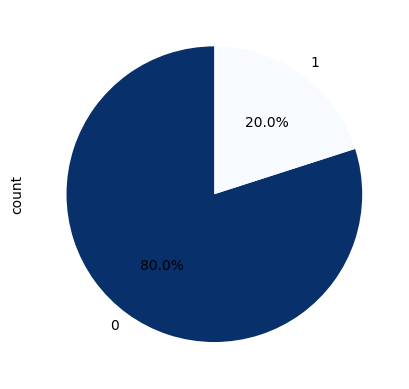

In [25]:
df['default'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Blues_r')
plt.show()

The pie chart suggests data imbalance when class 1 only accounts 20%. SMOTE will be applied to balance the data.

Transform categorical data

In [26]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

cat_cols = ['loan_reason','occupation']
encoding_mapping = {}
for col in cat_cols:
    df[col] = enc.fit_transform(df[col])
    encoding_mapping[col] = {str(label): int(encoded_value) for label, encoded_value in zip(enc.classes_, enc.transform(enc.classes_))}
# Save encoding mapping to a JSON file
with open('encoding_mapping.json', 'w') as json_file:
    json.dump(encoding_mapping, json_file, indent=2)  # indent for pretty formatting
# Print the encoding mapping
for col, mapping in encoding_mapping.items():
    print(f"{col} encoding:")
    for label, encoded_value in mapping.items():
        print(f'"{label}": {encoded_value}')
    print()
import json
with open('mapping_categoricalcolumns.json', 'w') as json_file:
    json.dump(encoding_mapping, json_file)

loan_reason encoding:
"DebtCon": 0
"HomeImp": 1
"Unknown": 2

occupation encoding:
"Mgr": 0
"Office": 1
"Other": 2
"ProfExe": 3
"Sales": 4
"Self": 5



Data Correlation

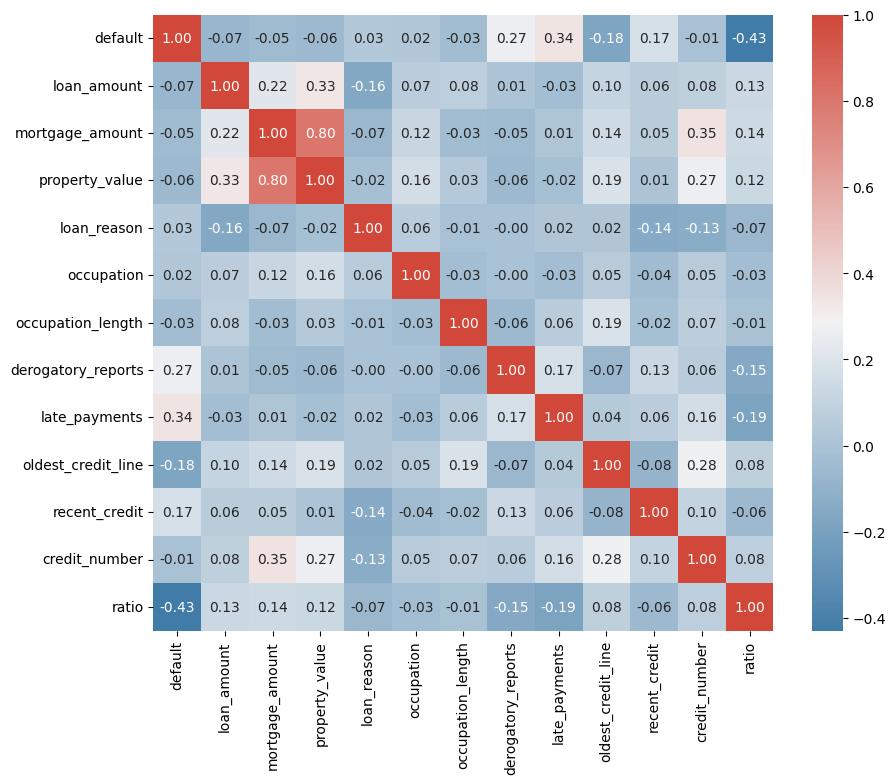

In [27]:
corr = df.drop(columns='id').corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 15, as_cmap=True)

# plotting
plt.figure(figsize=(10,8))
sns.heatmap(data=corr,annot=True, cmap=cmap,fmt=".2f")
plt.show()

VIF: Multicolinearity

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
variables = df.drop(columns={'default','id'},axis=1)
x = add_constant(variables)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range (x.shape[1])]
vif['features'] = x.columns
vif = vif.sort_values(by='VIF', ascending=False)
vif

,VIF,features
0,16.515312,const
3,3.151267,property_value
2,3.077853,mortgage_amount
11,1.293191,credit_number
1,1.188019,loan_amount
9,1.163761,oldest_credit_line
8,1.101298,late_payments
12,1.100020,ratio
7,1.079280,derogatory_reports
4,1.077435,loan_reason


Although property_value and mortgage_amount seems to cause multicolinearity, multiple trials of modeling showed that keeping these features would result in a higher performance.

##### Split data

In [29]:
x = df.drop(columns={'default', 'id'})
y = df['default']

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test , y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)

In [31]:
print("Training set shape:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print(" ------- ")

print("Testing set shape:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Training set shape:
x_train: (4418, 12)
y_train: (4418,)
 ------- 
Testing set shape:
x_test: (780, 12)
y_test: (780,)


##### Scale data

In [32]:
from sklearn.preprocessing import MinMaxScaler

# scaling train data
mms = MinMaxScaler()
mms.fit(x_train)
x_train= mms.transform(x_train)

# scaling test dat with train data scale range
x_test= mms.transform(x_test)

In [33]:
import joblib
joblib.dump(mms, 'minmaxscaler.pkl')

['minmaxscaler.pkl']

##### Balance data

In [34]:
# Initialize SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# Apply SMOTE to the dataset
x_train, y_train = smote.fit_resample(x_train, y_train)


In [35]:
pd.DataFrame(y_train).value_counts()

default
0          3532
1          3532
Name: count, dtype: int64

In [36]:
print("Training set shape:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print(" ------- ")

print("Testing set shape:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Training set shape:
x_train: (7064, 12)
y_train: (7064,)
 ------- 
Testing set shape:
x_test: (780, 12)
y_test: (780,)


### **Modeling: Machine Learning Algorithms**

In [37]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##### Logistic Regression

Accuracy = 0.8269230769230769
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       624
           1       0.55      0.74      0.63       156

    accuracy                           0.83       780
   macro avg       0.74      0.79      0.76       780
weighted avg       0.85      0.83      0.84       780



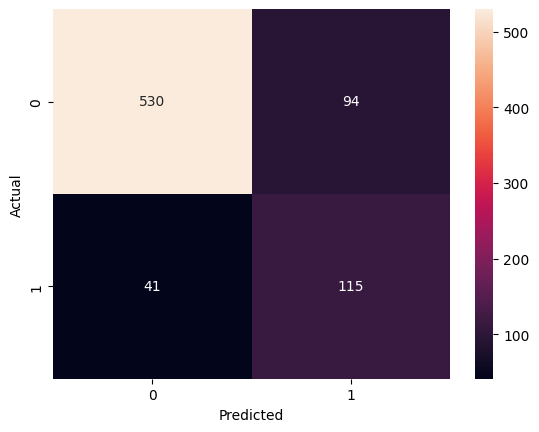

In [38]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression() #select the algorithm
reg.fit(x_train,y_train) # we fit the algorithm with the training data and the training output

y_hat = reg.predict(x_test) # y_hat holding the prediction made with the algorithm using x_test

# Accuracy
print('Accuracy = ' + str(accuracy_score(y_test,y_hat)))

# cassification report
print(classification_report(y_test,y_hat))

# confustion matrix
cm = confusion_matrix(y_test, y_hat)
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

##### Decision Tree

Accuracy = 0.8589743589743589
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       624
           1       0.64      0.67      0.65       156

    accuracy                           0.86       780
   macro avg       0.78      0.79      0.78       780
weighted avg       0.86      0.86      0.86       780



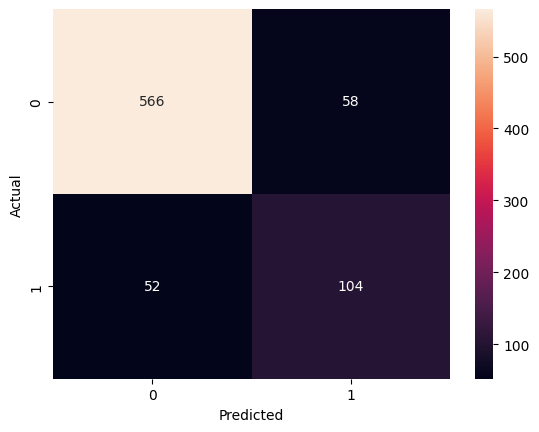

In [39]:
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
dd = DecisionTreeClassifier()
dd.fit(x_train,y_train)
y_hat = dd.predict(x_test) # y_hat holding the prediction made with the algorithm using x_test

# Accuracy
print('Accuracy = ' + str(accuracy_score(y_test,y_hat)))

# cassification report
print(classification_report(y_test,y_hat))

# confustion matrix
cm = confusion_matrix(y_test, y_hat)
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

##### Grid Search with Traditional Machine Learning Algorithms

In [40]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC

# # Initialize basic models
# lr = LogisticRegression()
# knn = KNeighborsClassifier()
# dt = DecisionTreeClassifier()
# rf = RandomForestClassifier()
# svm = SVC()

# # Initialize parameters for models
# logistic_params = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga']
# }

# knn_params = {
#     'n_neighbors': [3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]  # 1 for Manhattan distance (L1), 2 for Euclidean distance (L2)
# }

# decision_tree_params = {
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best', 'random'],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# random_forest_params = {
#     'n_estimators': [100, 200, 300],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# svm_params = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'gamma': ['scale', 'auto']
# }

# # List of parameter grids
# list_params = [logistic_params, knn_params, decision_tree_params, random_forest_params, svm_params]

# # List of models
# models = [lr, knn, dt, rf, svm]
# model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM']

# optimized_params = {}

# for model, param, name in zip(models, list_params, model_names):
#     grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, scoring='accuracy')
#     grid_search.fit(x_train, y_train)
    
#     best_params = grid_search.best_params_
#     best_model = grid_search.best_estimator_
#     optimized_params[name] = best_params
#     print(f'Best parameters for {name}: {best_params}')

# optimized_params


##### XGBoost

In [41]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Initialize the XGBoost classifier
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Define the parameter grid for XGBoost
# xgb_params = {
#     'max_depth': [3, 6, 9],  # Maximum depth of a tree
#     'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Learning rate
#     'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instance
#     'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
#     'n_estimators': [50, 100, 200],  # Number of boosting rounds
#     'objective': ['binary:logistic'],  # Binary classification
#     'seed': [42]  # Random seed for reproducibility
# }

# # Perform GridSearchCV to find the best parameters for XGBoost
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(x_train, y_train)

# # Get the best parameters and the best model
# XGB = grid_search.best_params_
# best_xgb_model = grid_search.best_estimator_

# print(f'Best parameters for XGBoost: {XGB}')

In [42]:
optimized_params = {'Logistic Regression': {'C': 1, 'penalty': 'l2', 'solver': 'saga'},
 'KNN': {'n_neighbors': 3, 'p': 1, 'weights': 'distance'},
 'Decision Tree': {'criterion': 'entropy',
  'max_depth': 30,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'splitter': 'random'},
 'Random Forest': {'criterion': 'entropy',
  'max_depth': 40,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 'SVM': {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'},
 'XGB':{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.6}}


In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# a function to log results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def extract_results(algorithm,y_true, y_pred, target_class = 1):
    results = {}
    results['algorithm'] = algorithm
    results['accuracy'] = accuracy_score(y_test,y_pred)
    results['recall'] = recall_score(y_true, y_pred, pos_label=target_class)
    results['precision'] = precision_score(y_true, y_pred, pos_label=target_class)
    results['f1_score'] = f1_score(y_true, y_pred, pos_label=target_class)
    results['roc_auc'] = roc_auc_score(y_true, y_pred)
    return results

# Initialize models with optimized parameters
lr = LogisticRegression(**optimized_params['Logistic Regression'])
knn = KNeighborsClassifier(**optimized_params['KNN'])
dt = DecisionTreeClassifier(**optimized_params['Decision Tree'])
rf = RandomForestClassifier(**optimized_params['Random Forest'])
svm = SVC(**optimized_params['SVM'], probability=True)  # SVM needs probability=True for ROC curve
xgb_model = xgb.XGBClassifier(**optimized_params['XGB'])

# Initialize a list to save results of models
list_result = []

# Train and extract results
models = [lr, knn, dt, rf, svm, xgb_model]
models_name = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM', 'XGBoost']
for model, name in zip(models, models_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # For SVM and XGBoost, also get predicted probabilities for ROC curve and AUC
    if name in ['SVM', 'XGBoost']:
        y_pred_prob = model.predict_proba(x_test)[:, 1]
    else:
        y_pred_prob = None

    # Extract results (assuming extract_results is defined elsewhere)
    model_result = extract_results(algorithm=name, y_true=y_test, y_pred=y_pred, target_class=1)
    list_result.append(model_result)

df_result = pd.DataFrame(list_result)
df_result


,algorithm,accuracy,recall,precision,f1_score,roc_auc
0,Logistic Regression,0.824359,0.730769,0.545455,0.624658,0.789263
1,KNN,0.937179,0.769231,0.902256,0.830450,0.874199
2,Decision Tree,0.865385,0.692308,0.654545,0.672897,0.800481
3,Random Forest,0.907692,0.788462,0.759259,0.773585,0.862981
4,SVM,0.898718,0.782051,0.730539,0.755418,0.854968
5,XGBoost,0.914103,0.794872,0.779874,0.787302,0.869391


In [45]:
import pickle

# Save the model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### **Modeling: Deep Learning**

##### Split data: with valid set

In [400]:
x = df.drop(columns={'default', 'id'})
y = df['default']

from sklearn.model_selection import train_test_split
x_train_valid, x_test , y_train_valid, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

x_train, x_valid , y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.1, random_state=42, stratify=y_train_valid)

In [401]:
print("Training set shape:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print(" ------- ")

print("Valid set shape:")
print("x_valid:", x_valid.shape)
print("y_valid:", y_valid.shape)

print(" ------- ")

print("Testing set shape:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Training set shape:
x_train: (4210, 12)
y_train: (4210,)
 ------- 
Valid set shape:
x_valid: (468, 12)
y_valid: (468,)
 ------- 
Testing set shape:
x_test: (520, 12)
y_test: (520,)


##### Scale data

In [402]:
from sklearn.preprocessing import MinMaxScaler

# scaling train data
mms = MinMaxScaler()
mms.fit(x_train)
x_train= mms.transform(x_train)

# scaling valid data
x_valid= mms.transform(x_valid)

# scaling test dat with train data scale range
x_test= mms.transform(x_test)

##### Balance data

In [403]:
# Initialize SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# Apply SMOTE to the dataset
x_train, y_train = smote.fit_resample(x_train, y_train)
pd.DataFrame(y_train).value_counts()

default
0          3366
1          3366
Name: count, dtype: int64

In [404]:
print("Training set shape:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print(" ------- ")

print("Valid set shape:")
print("x_valid:", x_valid.shape)
print("y_valid:", y_valid.shape)

print(" ------- ")

print("Testing set shape:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Training set shape:
x_train: (6732, 12)
y_train: (6732,)
 ------- 
Valid set shape:
x_valid: (468, 12)
y_valid: (468,)
 ------- 
Testing set shape:
x_test: (520, 12)
y_test: (520,)


##### Modeling

In [405]:
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Nadam, RMSprop, Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [406]:
def basic_model(x_size, y_size):
    t_model = Sequential()

    # input layer
    t_model.add(Dense(16, activation="relu", input_shape=(x_size,)))

    # output layer
    t_model.add(Dense(y_size, activation='sigmoid'))
    return(t_model)

def best_model(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(64, activation="relu", input_shape=(x_size,)))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(64, activation="relu"))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(64, activation="relu"))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(32, activation="relu"))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(y_size, activation='sigmoid'))
    return t_model

def enhanced_model(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(128, activation="relu", input_shape=(x_size,)))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(128, activation="relu"))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(64, activation="relu"))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(32, activation="relu"))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(y_size, activation='sigmoid'))
    return t_model


In [407]:
model_tf = enhanced_model(x_train.shape[1], 1)
model_tf.summary()

c:\Users\ADMIN\anaconda3\envs\ai_modeling\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,545 (111.50 KB)

 Trainable params: 28,545 (111.50 KB)

 Non-trainable params: 0 (0.00 B)

In [408]:
model_tf.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)
#RMSprop(learning_rate=0.001)
#Adam(learning_rate=0.001)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=70,
                                        restore_best_weights=True,
                                        verbose=1)

# Fit the model
history = model_tf.fit(x_train, y_train,
    batch_size=512,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping_callback]
)

Epoch 1/500
14/14 - 1s - 93ms/step - accuracy: 0.5064 - loss: 0.6946 - val_accuracy: 0.7671 - val_loss: 0.6837
Epoch 2/500
14/14 - 0s - 5ms/step - accuracy: 0.5475 - loss: 0.6864 - val_accuracy: 0.7521 - val_loss: 0.6691
Epoch 3/500
14/14 - 0s - 5ms/step - accuracy: 0.6064 - loss: 0.6711 - val_accuracy: 0.8526 - val_loss: 0.5761
Epoch 4/500
14/14 - 0s - 5ms/step - accuracy: 0.6502 - loss: 0.6473 - val_accuracy: 0.8162 - val_loss: 0.5449
Epoch 5/500
14/14 - 0s - 5ms/step - accuracy: 0.6921 - loss: 0.6087 - val_accuracy: 0.8248 - val_loss: 0.4932
Epoch 6/500
14/14 - 0s - 9ms/step - accuracy: 0.7304 - loss: 0.5772 - val_accuracy: 0.8462 - val_loss: 0.4537
Epoch 7/500
14/14 - 0s - 5ms/step - accuracy: 0.7501 - loss: 0.5478 - val_accuracy: 0.8632 - val_loss: 0.4209
Epoch 8/500
14/14 - 0s - 5ms/step - accuracy: 0.7611 - loss: 0.5430 - val_accuracy: 0.8504 - val_loss: 0.4497
Epoch 9/500
14/14 - 0s - 5ms/step - accuracy: 0.7757 - loss: 0.5208 - val_accuracy: 0.8718 - val_loss: 0.3864
Epoch 10/

##### Model Evaluation

In [409]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

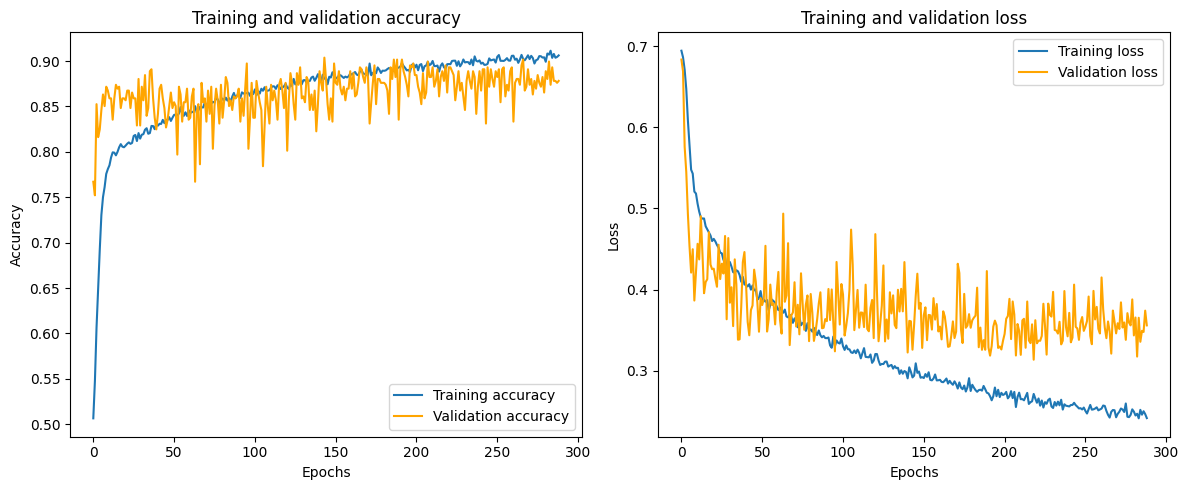

In [410]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='orange')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color='orange')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

# Call the function to plot the history
plot_history(history)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy = 0.9076923076923077
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       416
           1       0.75      0.82      0.78       104

    accuracy                           0.91       520
   macro avg       0.85      0.87      0.86       520
weighted avg       0.91      0.91      0.91       520



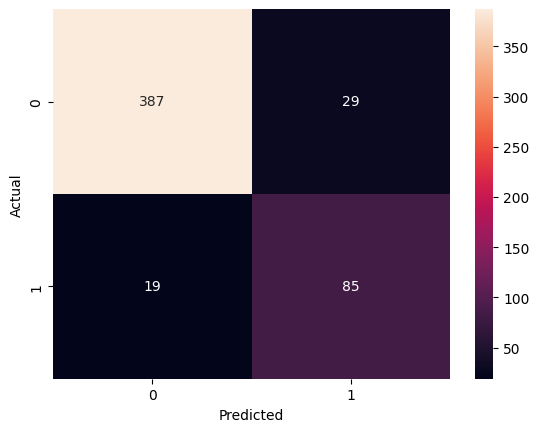

In [411]:
# Get predicted probabilities
y_pred_prob = model_tf.predict(x_test)

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype("int32")

# Accuracy
print('Accuracy = ' + str(accuracy_score(y_test,y_pred)))

# cassification report
print(classification_report(y_test,y_pred))

# confustion matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


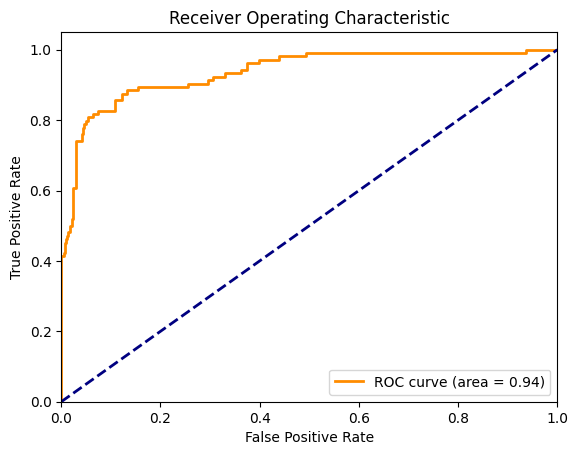

In [412]:
y_pred_prob = model_tf.predict(x_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [417]:
def extract_results(algorithm,y_true, y_pred, target_class = 1):
    results = {}
    results['algorithm'] = algorithm
    results['accuracy'] = accuracy_score(y_test,y_pred)
    results['recall'] = recall_score(y_true, y_pred, pos_label=target_class)
    results['precision'] = precision_score(y_true, y_pred, pos_label=target_class)
    results['f1_score'] = f1_score(y_true, y_pred, pos_label=target_class)
    results['roc_auc'] = roc_auc_score(y_true, y_pred)
    return results


y_pred_prob = model_tf.predict(x_test)

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype("int32")

list_result.append(extract_results('ANN',y_test, y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [414]:
model_tf.save("ann_model.keras")

### **Model Comparison**

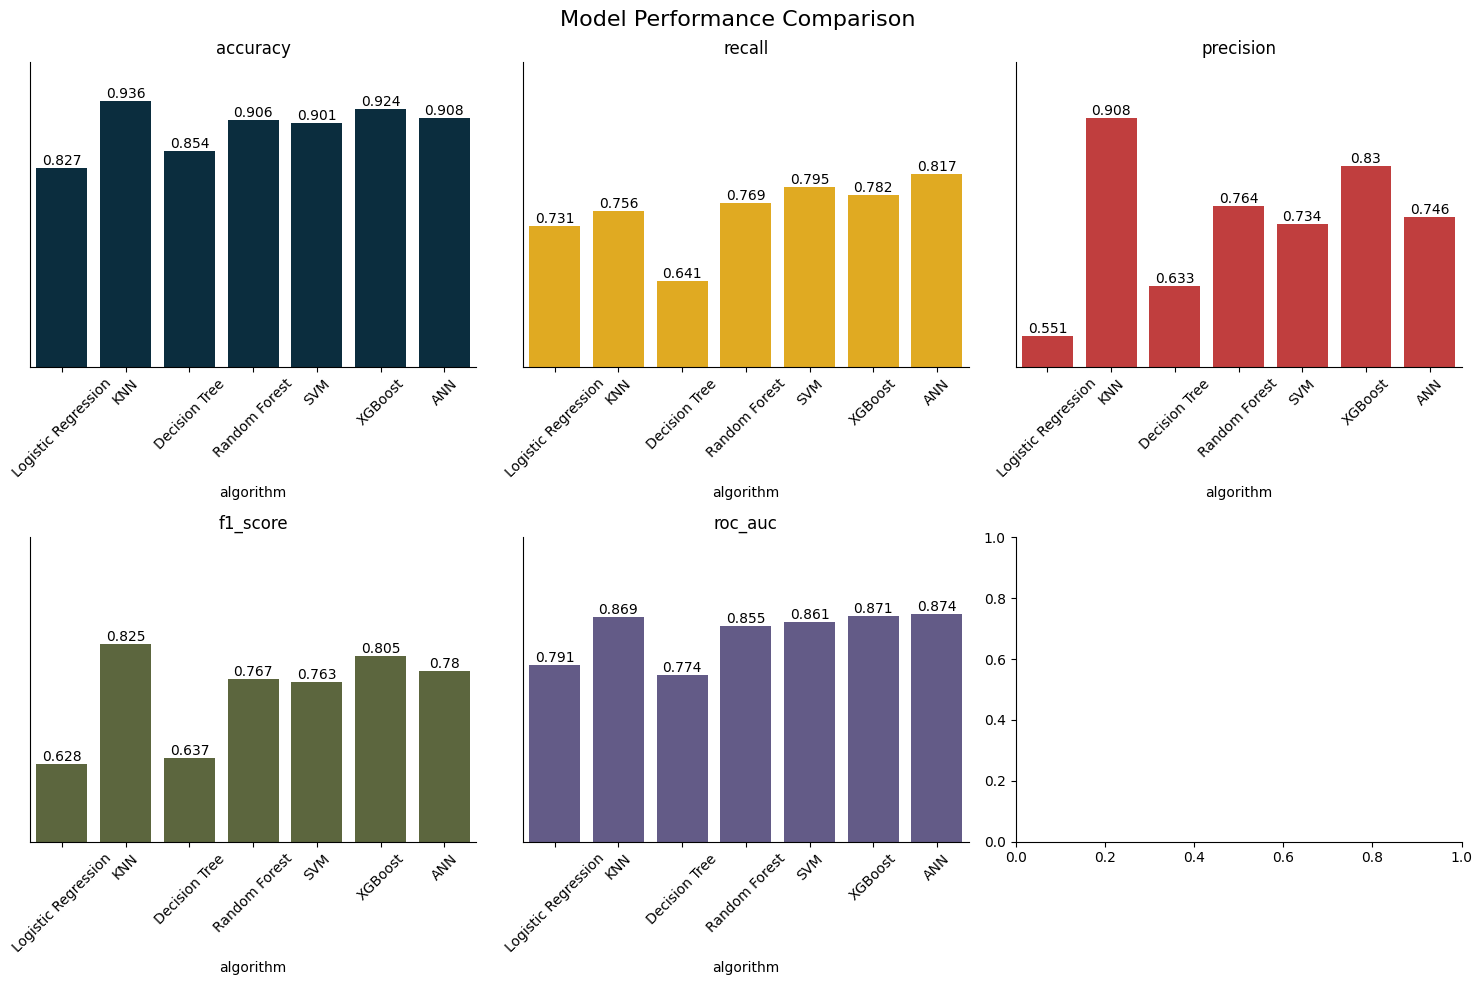

In [418]:
import seaborn as sns
import matplotlib.pyplot as plt

df_result = pd.DataFrame(list_result)
df_result = df_result.round(3)

# Prepare figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
cols_score = ['accuracy', 'recall', 'precision', 'f1_score', 'roc_auc']
custom_palette = ['#023047', '#ffb703', '#d62828', '#606c38', '#5e548e']

# Plot
for ind, col in enumerate(cols_score):
    ax = axes[ind // 3, ind % 3]  
    sns.barplot(data=df_result, x='algorithm', y=col, color=custom_palette[ind], ax=ax)
    ax.set_title(col)
    ax.tick_params(rotation=45)
    ax.grid(False)
    ax.set_ylim(0.5,1)
    ax.yaxis.set_visible(False)
    for container in ax.containers:
        ax.bar_label(container)

# Set figure title
fig.suptitle("Model Performance Comparison", fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()
